<a href="https://colab.research.google.com/github/JVR27XD/MobileSAM/blob/main/NanoSAM2TFG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Preparar entorno
!git clone https://github.com/NVIDIA-AI-IOT/nanosam.git
%cd /content/nanosam

# Instalar dependencias básicas
!pip install torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2 --index-url https://download.pytorch.org/whl/cu121
!pip install opencv-python matplotlib


Cloning into 'nanosam'...
remote: Enumerating objects: 1309, done.
remote: Total 1309 (delta 0), reused 0 (delta 0), pack-reused 1309 (from 1)
Receiving objects: 100% (1309/1309), 97.56 MiB | 21.78 MiB/s, done.
Resolving deltas: 100% (749/749), done.
/content/nanosam
Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 GB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 127.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 100.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 27.7 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.2.0
    Uninstalling triton-3.2.0:
      Successfully uninstalled triton-3.2.0
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cu124
    Uninstalling torch-2.6.0+cu124:
      Successfully uninstalled torch-2.6.0+cu124
  Attempting uninstall: torchvision


In [4]:
# Descargar checkpoint oficial MobileSAM (TinyViT)
!mkdir -p assets
!wget https://github.com/ChaoningZhang/MobileSAM/blob/master/weights/mobile_sam.pt -O assets/mobile_sam.pt


--2025-06-26 13:49:13--  https://github.com/ChaoningZhang/MobileSAM/blob/master/weights/mobile_sam.pt
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘assets/mobile_sam.pt’

assets/mobile_sam.p     [ <=>                ] 174.48K  --.-KB/s    in 0.1s    

2025-06-26 13:49:14 (1.18 MB/s) - ‘assets/mobile_sam.pt’ saved [178665]



In [5]:
# Instalar NanoSAM
%cd /content/nanosam
!pip install -e .


/content/nanosam
Obtaining file:///content/nanosam
  Preparing metadata (setup.py) ... done
  Running setup.py develop for nanosam


In [6]:
!pip install torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2 --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121


In [9]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)


2.1.2+cu121
0.16.2+cu121


In [8]:
# Forzar numpy 1.26.4
!pip install numpy==1.26.4 --force-reinstall


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 109.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
!pip install onnxruntime


!pip install onnxruntime-gpu

!pip install onnxruntime-gpu --extra-index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/

  Using cached onnxruntime_gpu-1.22.0-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (4.9 kB)
Using cached onnxruntime_gpu-1.22.0-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (283.2 MB)
Looking in indexes: https://pypi.org/simple, https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/


In [2]:
import onnxruntime as ort
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


In [3]:
def preprocess_image(image, size: int = 1024):
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    image_mean = np.array([123.675, 116.28, 103.53]).reshape(3, 1, 1)
    image_std = np.array([58.395, 57.12, 57.375]).reshape(3, 1, 1)

    aspect_ratio = image.width / image.height
    if aspect_ratio >= 1:
        resize_width = size
        resize_height = int(size / aspect_ratio)
    else:
        resize_height = size
        resize_width = int(size * aspect_ratio)

    image_resized = image.resize((resize_width, resize_height))
    image_np = np.asarray(image_resized).transpose(2, 0, 1)  # (3, H, W)
    image_np = (image_np - image_mean) / image_std

    image_tensor = np.zeros((1, 3, size, size), dtype=np.float32)
    image_tensor[0, :, :resize_height, :resize_width] = image_np

    return image_tensor

In [4]:
class OnnxNanosamPredictor:
    def __init__(self, image_encoder_path, mask_decoder_path, image_encoder_size=1024, orig_image_encoder_size=1024):
        self.image_encoder_session = ort.InferenceSession(
            image_encoder_path,
            providers=["CUDAExecutionProvider", "CPUExecutionProvider"]
        )
        self.mask_decoder_session = ort.InferenceSession(
            mask_decoder_path,
            providers=["CUDAExecutionProvider", "CPUExecutionProvider"]
        )
        self.image_encoder_size = image_encoder_size
        self.orig_image_encoder_size = orig_image_encoder_size

    def set_image(self, image):
        self.image = image
        self.image_tensor = preprocess_image(image, self.image_encoder_size)
        self.features = self.image_encoder_session.run(
            ["image_embeddings"],
            {"image": self.image_tensor}
        )[0]

    def predict(self, points, point_labels):
        points_arr = np.array(points).astype(np.float32)
        labels_arr = np.array(point_labels).astype(np.float32)

        input_points = points_arr[None, :, :]
        input_labels = labels_arr[None, :]

        mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
        has_mask_input = np.zeros(1, dtype=np.float32)

        outputs = self.mask_decoder_session.run(
            ["iou_predictions", "low_res_masks"],
            {
                "image_embeddings": self.features,
                "point_coords": input_points,
                "point_labels": input_labels,
                "mask_input": mask_input,
                "has_mask_input": has_mask_input
            }
        )
        iou_predictions, low_res_masks = outputs
        return iou_predictions, low_res_masks


In [5]:




# ONNX
image_encoder_path = "/content/drive/MyDrive/Colab Notebooks/TFG/NanoSam/resnet18_image_encoder.onnx"
mask_decoder_path = "/content/drive/MyDrive/Colab Notebooks/TFG/NanoSam/mobile_sam_mask_decoder.onnx"

predictor = OnnxNanosamPredictor(
    image_encoder_path,
    mask_decoder_path
)

image = Image.open("/content/nanosam/assets/dogs.jpg")

predictor.set_image(image)

In [6]:
bbox = [100, 100, 850, 759]  # x0, y0, x1, y1
points = np.array([
    [bbox[0], bbox[1]],
    [bbox[2], bbox[3]]
])
point_labels = np.array([2, 3])

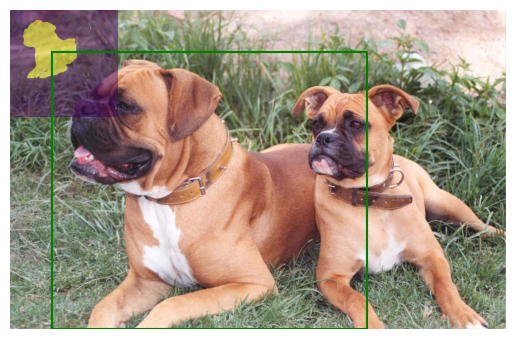

In [7]:
iou_pred, low_res_mask = predictor.predict(points, point_labels)
mask = (low_res_mask[0, 0] > 0).astype(np.uint8)

plt.imshow(image)
plt.imshow(mask, alpha=0.5)
x = [bbox[0], bbox[2], bbox[2], bbox[0], bbox[0]]
y = [bbox[1], bbox[1], bbox[3], bbox[3], bbox[1]]
plt.plot(x, y, 'g-')
plt.axis('off')
plt.show()

In [15]:

import onnxruntime as ort
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import cv2

def preprocess_image(image, size: int = 1024):
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    image_mean = np.array([123.675, 116.28, 103.53]).reshape(3, 1, 1)
    image_std = np.array([58.395, 57.12, 57.375]).reshape(3, 1, 1)

    aspect_ratio = image.width / image.height
    if aspect_ratio >= 1:
        resize_width = size
        resize_height = int(size / aspect_ratio)
    else:
        resize_height = size
        resize_width = int(size * aspect_ratio)

    image_resized = image.resize((resize_width, resize_height))
    image_np = np.asarray(image_resized).transpose(2, 0, 1)
    image_np = (image_np - image_mean) / image_std

    image_tensor = np.zeros((1, 3, size, size), dtype=np.float32)
    image_tensor[0, :, :resize_height, :resize_width] = image_np

    return image_tensor

def upscale_mask(mask, image_shape, size=256):
    if image_shape[1] > image_shape[0]:
        lim_x = size
        lim_y = int(size * image_shape[0] / image_shape[1])
    else:
        lim_x = int(size * image_shape[1] / image_shape[0])
        lim_y = size

    mask = mask[:, :, :lim_y, :lim_x]
    mask = F.interpolate(mask, size=image_shape, mode='bilinear', align_corners=False)

    return mask

#  OnnxNanosamPredictor
class OnnxNanosamPredictor:
    def __init__(self, image_encoder_path, mask_decoder_path, image_encoder_size=1024, orig_image_encoder_size=1024):
        self.image_encoder_session = ort.InferenceSession(
            image_encoder_path,
            providers=["CUDAExecutionProvider", "CPUExecutionProvider"]
        )
        self.mask_decoder_session = ort.InferenceSession(
            mask_decoder_path,
            providers=["CUDAExecutionProvider", "CPUExecutionProvider"]
        )
        self.image_encoder_size = image_encoder_size
        self.orig_image_encoder_size = orig_image_encoder_size

    def set_image(self, image):
        self.image = image
        self.image_tensor = preprocess_image(image, self.image_encoder_size)
        self.features = self.image_encoder_session.run(
            ["image_embeddings"],
            {"image": self.image_tensor}
        )[0]

    def predict(self, points, point_labels):
        points_arr = np.array(points).astype(np.float32)
        labels_arr = np.array(point_labels).astype(np.float32)

        input_points = points_arr[None, :, :]
        input_labels = labels_arr[None, :]

        mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
        has_mask_input = np.zeros(1, dtype=np.float32)

        outputs = self.mask_decoder_session.run(
            ["iou_predictions", "low_res_masks"],
            {
                "image_embeddings": self.features,
                "point_coords": input_points,
                "point_labels": input_labels,
                "mask_input": mask_input,
                "has_mask_input": has_mask_input
            }
        )
        iou_predictions, low_res_masks = outputs
        return iou_predictions, low_res_masks


Imagen: width=1180, height=760
low_res_mask shape: (1, 4, 256, 256)


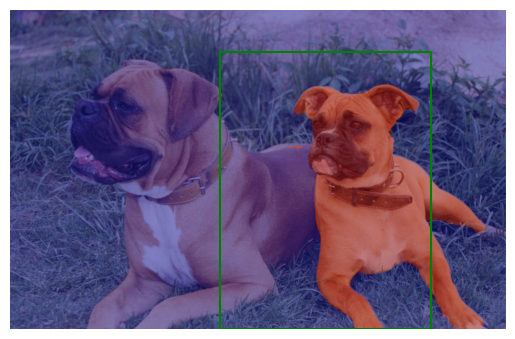

In [16]:
# Rutas de los modelos
image_encoder_path = "/content/drive/MyDrive/Colab Notebooks/TFG/NanoSam/resnet18_image_encoder.onnx"
mask_decoder_path = "/content/drive/MyDrive/Colab Notebooks/TFG/NanoSam/mobile_sam_mask_decoder.onnx"

# Crear predictor
predictor = OnnxNanosamPredictor(image_encoder_path, mask_decoder_path)

# Cargar imagen
image = Image.open("/content/nanosam/assets/dogs.jpg")
width, height = image.size
print(f"Imagen: width={width}, height={height}")

predictor.set_image(image)

#  Bounding Box
bbox = [500, 100, 1000, 759]
points = np.array([
    [bbox[0], bbox[1]],
    [bbox[2], bbox[3]]
])
point_labels = np.array([2, 3])

iou_pred, low_res_mask = predictor.predict(points, point_labels)

print("low_res_mask shape:", low_res_mask.shape)

# Caso: (1, 4, 256, 256)
low_res_tensor = torch.from_numpy(low_res_mask[0, 0, :, :]).unsqueeze(0).unsqueeze(0).float()


# upscale
mask_upscaled = upscale_mask(low_res_tensor, (height, width)).squeeze().numpy()
mask = (mask_upscaled > 0.5).astype(np.uint8)

# Mostrar
plt.imshow(image)
plt.imshow(mask, alpha=0.5, cmap='jet')
x = [bbox[0], bbox[2], bbox[2], bbox[0], bbox[0]]
y = [bbox[1], bbox[1], bbox[3], bbox[3], bbox[1]]
plt.plot(x, y, 'g-')
plt.axis('off')
plt.show()


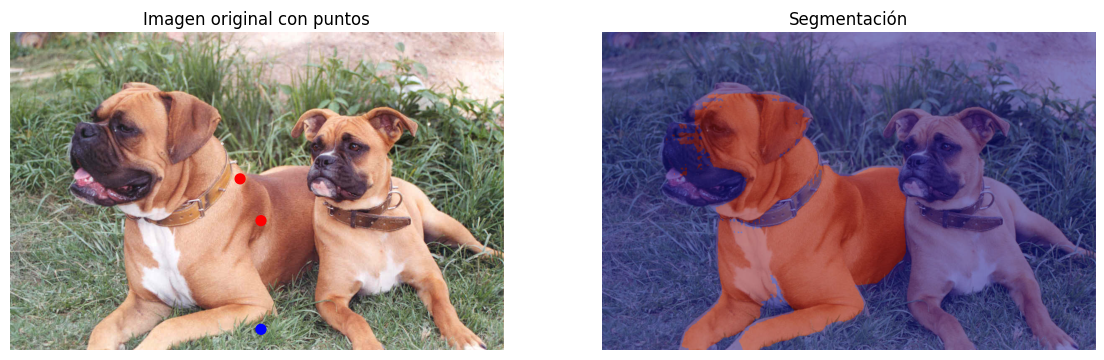

In [19]:
import matplotlib.pyplot as plt

# Datos
points = np.array([[550, 350], [600, 450], [600, 710]])
point_labels = np.array([1, 1, 0])

# Inferencia
iou_pred, low_res_mask = predictor.predict(points, point_labels)
low_res_tensor = torch.from_numpy(low_res_mask[0, 0, :, :]).unsqueeze(0).unsqueeze(0).float()
mask_upscaled = upscale_mask(low_res_tensor, (height, width)).squeeze().numpy()
mask = (mask_upscaled > 0.5).astype(np.uint8)

# Mostrar lado a lado
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Imagen original con puntos
axes[0].imshow(image)
axes[0].scatter(points[:, 0], points[:, 1], c=['red', 'red', 'blue'], s=50)
axes[0].set_title('Imagen original con puntos')
axes[0].axis('off')

# Segmentación
axes[1].imshow(image)
axes[1].imshow(mask, alpha=0.5, cmap='jet')
axes[1].set_title('Segmentación')
axes[1].axis('off')

plt.show()
